In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython.display as display
from skimage.io import imread
from collections import namedtuple

# Fourier Transform

The Fourier Transform converts a function of time to a function of frequency. In case of image processing the input image is the spatial domain and the output of the transformation represents the image in the frequency domain. 
The core idea of Fourier Transform is that everything can be represented by waves - a sequence of periodic functions i.e sine waves (sinosoids). 
So Fourier Transform is useful to decompose and analyse a signal in 1D or an image in 2D based by its frequencies. Furthermore, linear operations performed in one domain (time or frequency) have corresponding operations in the other domain, which are sometimes easier to perform. For example, the convolution in the time/spatial domain corresponds to ordinary multiplication in the frequency domain. After performing the desired operations, the transformation of the result can be made back to the time or spatial domain.


### Discrete Fourier Transform

Fourier Transform is a way to switch between two different representations of a signal:
* the time domain (a series of evenly spaced samples over time)
* the frequency domain (the amplitude and phase of waves, at different frequencies, that can be used to reconstruct the signal)

> Sine wave - the excursion around a circle happening in time
> characteristics of a sine wave $$y(t) = Asin(2\pi ft+\phi)$$
> * $A$ - amplitude - the peak deviation of the function from zero
> * $f$ - frequency - the number of cycles that occur each second = Hertz
> * $w = 2\pi f$ - angular frequency - radians per second
> * $\phi$ - phase - shifts (delay or advance)

#### Formal definition:

The discrete Fourier transform transforms a sequence of N complex numbers ${x_{n}}=x_{0},x_{1},\ldots,x_{N-1}$ into another sequence of complex numbers, ${X_{k}}=X_{0},X_{1},\ldots,X_{N-1}$ and vice versa:

$$ X_{k}=\sum_{n=0}^{N-1}x_{n} \cdot e^{-{\frac{i2\pi}{N}kn}} $$
$$x_{n}= \frac{1}{N} \cdot \sum_{k=0}^{N-1}X_{k} \cdot e^{\frac{i2\pi}{N}kn}$$

where:
* $N$ = the number of samples
* $n$ = the current sample
* $x_n$ = the value of the signal for the sample n
* $k$ = current frequency (0 Hz to N-1 Hz)
* $X_k$ = the result of the DFT - a complex number - real = amplitude and imaginary = phase

Also from Euler's formula:
$$ X_{k}=\sum_{n=0}^{N-1}x_{n} \cdot \bigg[\cos \bigg({\frac{2\pi}{N}}kn\bigg)-i \cdot \sin\bigg({\frac{2\pi}{N}}kn\bigg)\bigg] $$

But what does it mean?

> To find the energy at a particular frequency, spin your signal around a circle at that frequency and average the sampled points along the path (to find the "center of mass"). The trajectory of the center of mass is the signal's spectrum.

Here is a simple animation showing how we can wrap a signal - a simple sine wave $x_{n}$ with a frequency of 4 Hertz to a circle spiral for $n$ samples:

$$ g(n) = sin(4(2\pi)n) \cdot e^{-i(2\pi)kn} $$


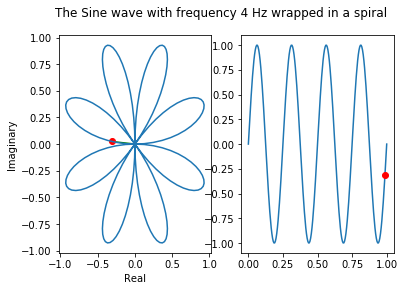

In [3]:
def animate_sine():
    min_x = 0
    max_spiral_x = 1

    time_period = 1 #seconds
    Fs = 200.0 #sampling rate
    Ts = time_period/Fs # sampling interval

    cycle = 2*np.pi
    frequency = 4 

    def sine_wave(n):
        return np.sin(n*cycle*frequency)

    def g(n):
        return (np.exp(cycle*1j*n)) * sine_wave(n)
    
    x = np.arange(min_x, max_spiral_x+Ts, Ts)

    fig, (ax_spiral, ax_sine) = plt.subplots(1, 2)
    fig.suptitle("The Sine wave with frequency %d Hz wrapped in a spiral" % frequency)

    p = g(x)
    line, = ax_spiral.plot([], [], 'g-', animated=True)
    point_of_spiral, = ax_spiral.plot(p.real, p.imag, "ro", animated=True)

    ax_spiral.set_xlabel("Real")
    ax_spiral.set_ylabel("Imaginary")
    ax_spiral.plot(np.real(g(x)), np.imag(g(x)))

    ax_sine.plot(x, sine_wave(x))
    point_of_sine, = ax_sine.plot(0, 0, "ro", animated=True)

    def update(x):
        p = g(x)
        line_x = np.linspace(0, p.real)
        line_y = (p.imag/p.real)*line_x if p.real != 0 else 0
        line.set_data(line_x, line_y)
        point_of_spiral.set_data(p.real, p.imag)
        point_of_sine.set_data(x, sine_wave(x))
        return point_of_spiral, line, point_of_sine

    anim = animation.FuncAnimation(fig,
                                   update,
                                   frames=np.linspace(min_x, max_spiral_x, 80, endpoint=False),
                                   interval=60,
                                   blit=True)
    return anim

anim = animate_sine()
display.HTML(anim.to_jshtml())

To have in mind:

* Euler's Formula - $e^{ix}$ produces a circle of radius 1
$$e^{ix} = cos(x) + isin(x)$$

<img src="euler-formula-circle.svg"  width="200" height="200"/>

* the exponential form of the complex number: $re^{ix}$ ;it turns out to be very useful as there are many cases (such as multiplication) where it is easier to use the $re^{ix}$ form rather than the $a+bi$ form.

* Euler's identity - $e^{i\pi} = -1$ or $e^{i\tau} = 1$


### Exploring DFT
Let’s write some code to find out what DFT is actually doing. We are implementing exactly the formula from the formal definition about DFT.

In [4]:
def dft1D_base(x, sign, factor):
    """
    Discrete Fourier Transform 1D
    """
    N = len(x)
    X = np.array([])
    for k in range(0, N):
        Xk = np.complex(0, 0)
        for n in range(0, N):
            exp = np.exp(sign*2*math.pi*k*n*1j/N)
            Xk += np.complex(x[n]) * exp
        X = np.append(X, [factor * Xk])
    return X

def dft1D(x):
    return dft1D_base(x, -1, 1)

def idft1D(X):
    return dft1D_base(X, 1, 1/len(X))

Now lets define a simple signal containing an addition of two sine waves. One with a frequency of 1 Hz and one with a frequency of 3 Hz.

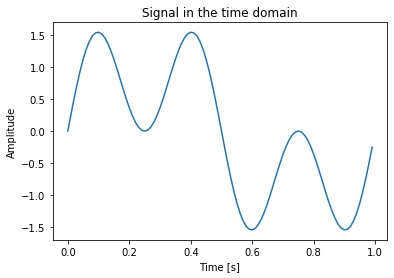

In [5]:
    time_period = 1  # 1 second
    Fs = 100.0  # sampling rate/frequency - the number of samples per second i.e. 1/T
    Ts = time_period/Fs  # sampling interval - the time interval between successive samples
    
    t = np.arange(0, time_period, Ts)  # time vector in seconds
    N = t.size
    f = np.linspace(0, 1/Ts, N)  # frequency vector - 1 / sampling_interval

    cycle = 2*np.pi
    frequency1 = 1 * cycle  # frequency of the signal 1 in Hertz
    frequency2 = 3 * cycle  # frequency of the signal 3 in Hertz

    y = np.sin(t*frequency1) + np.sin(t*frequency2)
    dft = dft1D(y)
    idft = idft1D(dft)

    plt.plot(t, y)
    plt.title("Signal in the time domain")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

Now, we can see the result of DFT - there are two frequencies - 1 and 3 Hertz, each with amplitude 1. We should double the amplitude as the frequencies are split to positive and negative ones but we plot only half of the spectrum, because that is the only half giving us real information. Also, we should divide the amplitude by number of sample points to get the correct amplitude.
>The negative frequency samples are also the inverse of the positive frequency samples. The highest positive (or negative) frequency sample is called the Nyquist frequency. This is the highest frequency component that should exist in the input series for the DFT to yield "uncorrupted" results. More specifically if there are no frequencies above Nyquist the original signal can be exactly reconstructed from the samples.

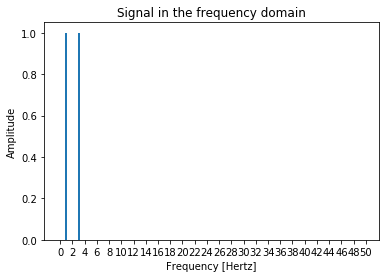

In [6]:
    plt.bar(f[:N//2], np.abs(dft)[:N//2]*2/N, width=0.3)
    plt.title("Signal in the frequency domain")
    plt.xticks(range(0, 51, 2))
    plt.xlabel("Frequency [Hertz]")
    plt.ylabel("Amplitude")
    plt.show()

And we actually have the entire information about the sine waves - the frequencies, their amplitude (energy) and phase offsets.
* Amplitude $A = |x_{n}| = \sqrt{x_{real}^2 + x_{imag}^2}$
* Phase $\phi = tan^{-1}\frac{x_{real}}{x_{imag}}$

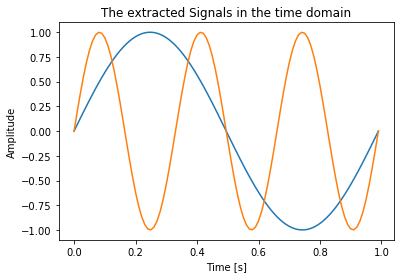

In [7]:
def extract_sines(possible_frequencies, dft_frequencies):
    """
    Extract sines from the frequency signal
    """
    functions = np.array([])
    for (frequency, dft) in zip(possible_frequencies, dft_frequencies):
        amplitude = math.sqrt(dft.real**2 + dft.imag**2)
        if(amplitude > 0.000001):
            # break the direct tie of the variables inside the main lambda
            # wrap them in another lambda called in the loop
            def sine(a, f): return (lambda t: (
                (1/a) * math.sin(f*2*math.pi*t)))
            wrapped_sine = np.vectorize((sine)(amplitude, frequency))
            functions = np.append(functions, [wrapped_sine])
    return functions
    
for sine in extract_sines(f[:N//2], dft[:N//2] * 2/N):
    plt.plot(t, sine(t))
plt.title("The extracted Signals in the time domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

Now, it remains just to check the result of the inverse DFT. And as it is expected, the result is our initial signal.

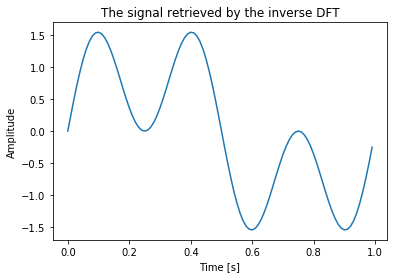

In [8]:
plt.plot(t, np.real(idft))
plt.title("The signal retrieved by the inverse DFT")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

We can even check with numpy that our results are correct.

In [9]:
N = 32
x = np.random.random(N)
dft = dft1D(x)
fft = np.fft.fft(x)
ifft = np.fft.ifft(fft)
print("DFT 1D has similar results as Numpy FFT: ", np.allclose(dft, fft))
print("Inverse DFT 1D has similar results as Numpy IFFT: ", np.allclose(idft1D(dft), ifft))

DFT 1D has similar results as Numpy FFT:  True
Inverse DFT 1D has similar results as Numpy IFFT:  True


However, if we run this code on more samples, it will become more obvious how slow it is. Actually, its time complexity is $O(n^{2})$ as we look through all the samples and all the frequencies.

In [10]:
x = np.random.random(100)
%timeit dft1D(x)
%timeit np.fft.fft(x)

47 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.39 µs ± 144 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Fast Fourier Transform

There is a solution to increase the time complexity and it was found by Cooley and Tukey - the Fast Fourier Transform (FFT) algorithm which recursively divides the DFT in smaller DFT’s bringing down the needed computation time drastically. FFT scales to $O(N log(N))$. An important requirement is that the number of the sampled points should be a power of 2. There is a solution to that, as well - zero padding (adding zeros to end of a time-domain signal to increase its length and to match the requirement).

The algorithm rearranges the DFT of the function $x_{n}$ into two parts:
* even-indexed samples $x_{2m} = x_{0}, x_{2}, ..., x_{N-2}$
* odd-indexed samples $x_{2m+1} = x_{1}, x_{3}, ..., x_{N-1}$
and then combines the two results to produce the whole DFT.
The idea can be performed recursively.

    $$ X_{k} = \sum_{m=0}^{N/2-1}x_{2m}e^{-\frac{2\pi i}{N}(2m)k} + \sum_{m=0}^{N/2-1}x_{2m+1}e^{-\frac{2\pi i}{N}(2m+1)k}$$
    $$ X_{k} = \underbrace{\sum_{m=0}^{N/2-1}x_{2m}e^{-\frac{2\pi i}{N/2}mk}}_\textrm{DFT of even-indexed $x_{n}$} + e^{-\frac{2\pi i}{N}k} \underbrace{\sum_{m=0}^{N/2-1}x_{2m+1}e^{-\frac{2\pi i}{N/2}mk}}_\textrm{DFT of odd-indexed part of $x_{n}$} = E_{k} +  e^{-\frac{2\pi i}{N}k} O_{k} $$
    
    
Now, we have divided the samples into 2 parts but what about the frequencies.
    $$  X_{k+\frac{N}{2}} = \sum_{m=0}^{N/2-1}x_{2m}e^{-\frac{2\pi i}{N/2}m(k+\frac{N}{2})} + e^{-\frac{2\pi i}{N}(k+\frac{N}{2})} \sum_{m=0}^{N/2-1}x_{2m+1}e^{-\frac{2\pi i}{N/2}m(k+\frac{N}{2})} $$
    $$  X_{k+\frac{N}{2}} = \sum_{m=0}^{N/2-1}x_{2m}e^{-\frac{2\pi i}{N/2}mk}\underbrace{e^{-2\pi mi}}_\textrm{=1}+ e^{-\frac{2\pi i}{N}k} \underbrace{e^{-\pi i}}_\textrm{=-1}\sum_{m=0}^{N/2-1}x_{2m+1}e^{-\frac{2\pi i}{N/2}mk}\underbrace{e^{-2\pi mi}}_\textrm{=1} $$
     $$  X_{k+\frac{N}{2}} = \sum_{m=0}^{N/2-1}x_{2m}e^{-\frac{2\pi i}{N/2}mk} - e^{-\frac{2\pi i}{N}k} \sum_{m=0}^{N/2-1}x_{2m+1}e^{-\frac{2\pi i}{N/2}mk} = E_{k} - e^{-\frac{2\pi i}{N}k} O_{k} $$
     
     
As a result, the formulas that we use to implement the algorithm are:
     $$ X_{k} = E_{k} +  e^{-\frac{2\pi i}{N}k} O_{k} $$
     $$ X_{k+\frac{N}{2}} =  E_{k} - e^{-\frac{2\pi i}{N}k} O_{k} $$
     
>A root of unity - any complex number that yields 1 when raised to some positive integer power n
>
>$$ z^{n} = 1 $$
>$$ z = 1^{\frac{1}{n}} $$
>$$ 1 = 1 + i0 = e^{i0} = e^{i2\pi} = e^{i4\pi} = ... = e^{ik2\pi} $$
>$$ k \in \mathbb Z, k = 0,1,2,...,n-1 $$
>$$ z = e^{ik2\pi\frac{1}{n}}$$

So here is our faster implementation - FFT. However, it is still not the optimal solution as the explicit recursion is often avoided because of possible problems of stack overflows. Moreover, FFTPACK library realised in numpy and scipy is extremely optimized.

In [11]:
def fft1D_base(x, sign, factor, ft1D):
    # the input must be a power of 2
    # in order to work with arbitrary dimensions
    # to implement padding
    N = len(x)
    if(N <= 1):
        return x
    M = (int)(N/2)
    even = np.array(ft1D(x[0::2]))
    odd = np.array(ft1D(x[1::2]))

    X = np.zeros(N, dtype=complex)
    for k in range(0, M):
        exp = np.exp(sign*2*math.pi*k*1j/N)
        oddTerm = exp*odd[k]
        X[k] = factor*(even[k] + oddTerm)
        X[k+M] = factor*(even[k] - oddTerm)
    return X

def fft1D(x):
    return fft1D_base(x, -1, 1, fft1D)

def ifft1D(freqs):
    return fft1D_base(freqs, 1, 0.5, ifft1D)

Let's test again that everything is ok checking with numpy fft.

In [12]:
N = 32
x = np.random.random(N)
fft = np.fft.fft(x)
custom_fft = fft1D(x)
ifft = np.fft.ifft(fft)
print("FFT 1D matches Numpy FFT: ", np.allclose(custom_fft, fft))
print("Inverse FFT 1D matches Numpy FFT: ", np.allclose(ifft1D(custom_fft), ifft))

FFT 1D matches Numpy FFT:  True
Inverse FFT 1D matches Numpy FFT:  True


However, our method is good enough to finally implement Fourier Transform in 2D and process some images in a reasonable time.

### Discrete Fourier Transform in 2D

    Discrete Fourier Transform 2D

    1.) do 1D DFT on each row (real to complex)
    the first step yields an intermediary 'picture' in which
    the horizontal axis is frequency f and the vertical axis is space y
    2.) do 1D DFT on each column of the result (complex to complex)
    the second step is to apply 1D Fourier transform individually to
    the vertical line of the intermediate image 



In [13]:
def ft2D(image, ft):
    M, N = image.shape
    transformed_image = np.empty((M, N), dtype=complex)

    # DFT 1D on rows
    for m in range(0, M):
        transformed_image[m, :] = ft(image[m, :])

    # DFT 1D on columns
    for n in range(0, N):
        transformed_image[:, n] = ft(transformed_image[:, n])

    return transformed_image

def fft2D(image):
    return ft2D(image, fft1D)

def ifft2D(image):
    return ft2D(image, ifft1D)

### Images ...finally :))

- examples - pulse functions, sinosoids, explanations

- filters

- trying to reduce noise

In [14]:
Point = namedtuple('Point', 'x y')

def distance(p1, p2):
    return math.sqrt((p1.x-p2.x)**2 + (p1.y-p2.y)**2)

def filter_image(image, filter, update):
    rows, columns = image.shape
    center = Point(rows/2, columns/2)
    for r in range(0, rows):
        for c in range(0, columns):
            if(filter(distance(Point(r, c), center))):
                update(image, c, r)
    return image

def high_pass_filter(image, threshold=50):
    def hp(dist):
        return dist < threshold

    def update(image, c, r):
        image[c][r] = 0
    return filter_image(image, hp, update)

def low_pass_filter(image, threshold=50):
    def lp(dist):
        return dist >= threshold

    def update(image, c, r):
        image[c][r] = 1
    return filter_image(image, lp, update)

<function matplotlib.pyplot.show(*args, **kw)>

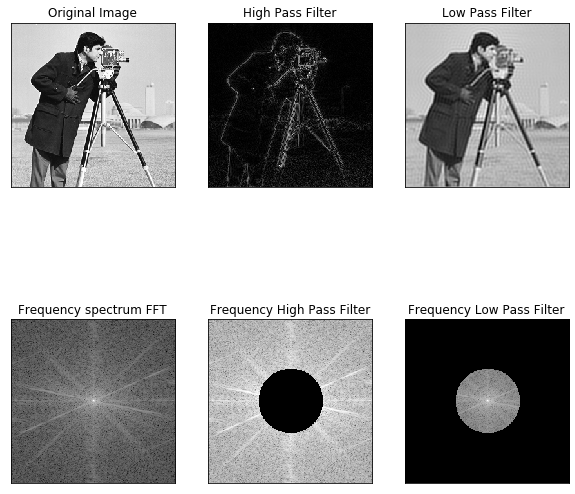

In [15]:
def logabs(m):
    return np.log(1+np.abs(m))

def shiftlog(m):
    return np.fft.fftshift(logabs(m))

original_image = imread("https://www.hlevkin.com/TestImages/cameraman.bmp")
fft = fft2D(original_image)
shifted_fft = np.fft.fftshift(fft)
hp_fft = high_pass_filter(shifted_fft.copy())
lp_fft = low_pass_filter(shifted_fft.copy())
hp = ifft2D(hp_fft)
lp = ifft2D(lp_fft)

cm = "gray"
_, ((ax_orig, ax_hp, ax_lp), 
    (ax_orig_freqs, ax_hp_freqs, ax_lp_freqs)) = plt.subplots(2, 3, figsize=(10, 10))
ax_orig.imshow(original_image, cmap=cm)
ax_orig.set_title("Original Image")
ax_hp.imshow(np.abs(hp), cmap=cm)
ax_hp.set_title("High Pass Filter")
ax_lp.imshow(np.abs(lp), cmap=cm)
ax_lp.set_title("Low Pass Filter")

ax_orig_freqs.imshow(shiftlog(fft), cmap=cm)
ax_orig_freqs.set_title("Frequency spectrum FFT")
ax_hp_freqs.imshow(logabs(hp_fft), cmap=cm)
ax_hp_freqs.set_title("Frequency High Pass Filter")
ax_lp_freqs.imshow(logabs(lp_fft), cmap=cm)
ax_lp_freqs.set_title("Frequency Low Pass Filter")

plt.setp([ax_orig, ax_hp, ax_lp, ax_orig_freqs,ax_hp_freqs, ax_lp_freqs], xticks=[], yticks=[])
plt.show()

## Bibliography
1. Grant Sanderson, But what is the Fourier Transform? A visual introduction. https://www.youtube.com/watch?v=spUNpyF58BY
2. Kalid Azad, An Interactive Guide To The Fourier Transform - https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/
3. Elan Ness-Cohn, Developing An Intuition for Fourier Transforms https://sites.northwestern.edu/elannesscohn/2019/07/30/developing-an-intuition-for-fourier-transforms/  
4. Stuart Riffle, Understanding the Fourier transform https://web.archive.org/web/20120418231513/http://www.altdevblogaday.com/2011/05/17/understanding-the-fourier-transform/
5. Ritchie Vink, Understanding the Fourier Transform by example https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/
6. Paul Bourke, DFT (Discrete Fourier Transform) FFT (Fast Fourier Transform) http://paulbourke.net/miscellaneous/dft/